In [7]:
# Machine learning for fire scar identification

# Experiment 1: Simple CNN structure vs. UNet
# Prototype trained for 3 epochs

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import rasterio
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, jaccard_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Paths
DATA_DIR = "data"

class FireDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        with rasterio.open(self.image_paths[idx]) as src:
            img = src.read()  # shape: (8, 512, 512)
        with rasterio.open(self.mask_paths[idx]) as src:
            mask = src.read(1)  # shape: (512, 512)

        img = img.astype(np.float32)
        img = (img - np.nanmean(img)) / (np.nanstd(img) + 1e-8)
        img[np.isnan(img)] = 0

        mask = (mask > 0).astype(np.uint8)

        if self.transform:
            img = self.transform(torch.tensor(img))
            mask = self.transform(torch.tensor(mask))

        return torch.tensor(img), torch.tensor(mask).long()

# Collect file paths
image_paths = sorted([os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.startswith("merged")])
mask_paths = sorted([os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.startswith("mask")])

# Dataset and split
dataset = FireDataset(image_paths, mask_paths)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)



In [8]:
### Models to choose from

# Simple CNN for segmentation
class FireSegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 256
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 128
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),          # 128
            nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU(),          # 256
            nn.ConvTranspose2d(16, 1, 2, stride=2),                      # 512
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.squeeze(1)  # shape: (B, 512, 512)

#UNet
class UNet(nn.Module):
    def __init__(self, in_channels=8, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Down part (encoder)
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(self.conv_block(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = self.conv_block(features[-1], features[-1]*2)

        # Up part (decoder)
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.up_convs.append(self.conv_block(feature*2, feature))

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]
        for i in range(len(self.ups)):
            x = self.ups[i](x)
            skip = skip_connections[i]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.up_convs[i](x)

        return self.final_conv(x).squeeze(1)



In [9]:
#Warning: This cell takes a long time to run (~2hrs)

# Model, loss, optimizer
model = UNet(in_channels=8, out_channels=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train_model(epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        # Wrap the DataLoader with tqdm to create a progress bar
        with tqdm(train_dl, unit='batch', desc=f'Epoch {epoch+1}/{epochs}') as pbar:
            for imgs, masks in pbar:
                imgs, masks = imgs.to(device), masks.to(device).float()

                preds = model(imgs)
                loss = criterion(preds, masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Update progress bar description with current loss
                pbar.set_postfix(loss=total_loss/len(train_dl))

        # Print loss for the epoch after the progress bar finishes
        print(f"Epoch {epoch+1} Loss: {total_loss/len(train_dl):.4f}")

        # Evaluate model after each epoch
        evaluate_model()

# Evaluation function
def evaluate_model():
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, masks in val_dl:
            imgs = imgs.to(device)
            preds = model(imgs)
            preds = torch.sigmoid(preds) > 0.5
            all_preds.append(preds.cpu().numpy().astype(np.uint8))
            all_targets.append(masks.numpy().astype(np.uint8))

    all_preds = np.concatenate(all_preds).reshape(-1)
    all_targets = np.concatenate(all_targets).reshape(-1)
    acc = accuracy_score(all_targets, all_preds)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)
    dice = f1_score(all_targets, all_preds, zero_division=0)
    
    print(f"Val Accuracy: {acc:.4f}") # Overall accuracy
    print(f"Val IoU     : {iou:.4f}") # Intersection over Union / Jaccard index
    print(f"Val Dice    : {dice:.4f}") # F1 score


train_model(epochs=3)


Epoch 1/3: 100%|██████████| 187/187 [38:19<00:00, 12.30s/batch, loss=0.0606]


Epoch 1 Loss: 0.0606
Val Accuracy: 0.9931
Val IoU     : 0.0000
Val Dice    : 0.0000


Epoch 2/3: 100%|██████████| 187/187 [38:20<00:00, 12.30s/batch, loss=0.0181] 


Epoch 2 Loss: 0.0181
Val Accuracy: 0.9950
Val IoU     : 0.4366
Val Dice    : 0.6078


Epoch 3/3: 100%|██████████| 187/187 [41:00<00:00, 13.16s/batch, loss=0.0189]


Epoch 3 Loss: 0.0189
Val Accuracy: 0.9952
Val IoU     : 0.3720
Val Dice    : 0.5423



Training complete. Showing example predictions...


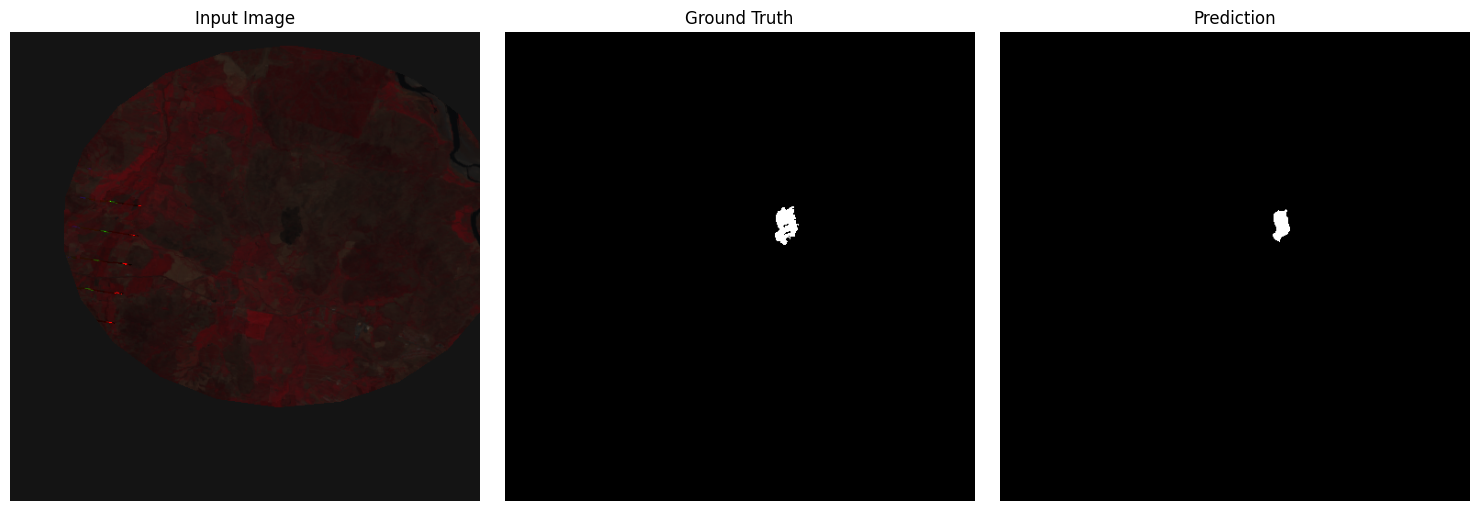

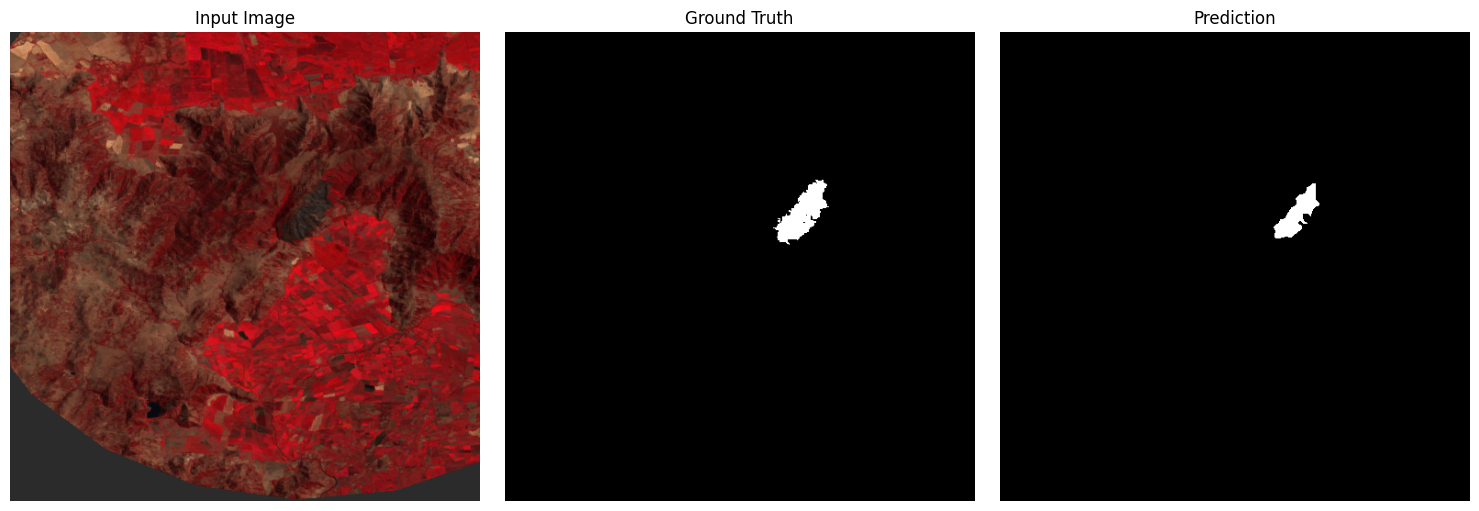

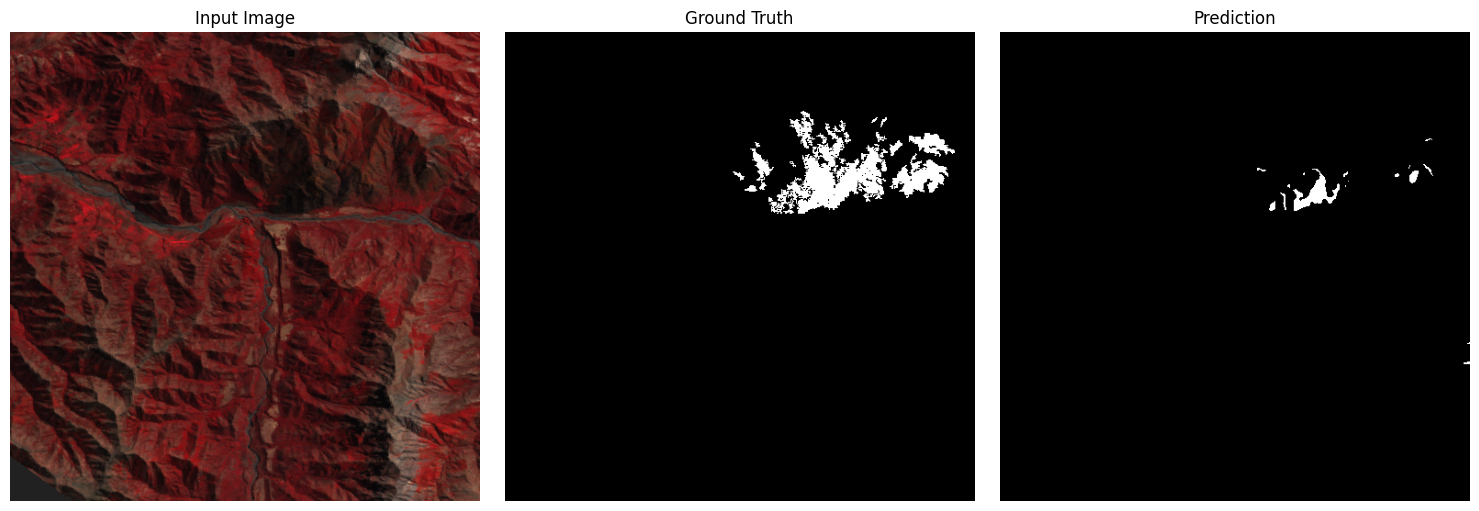

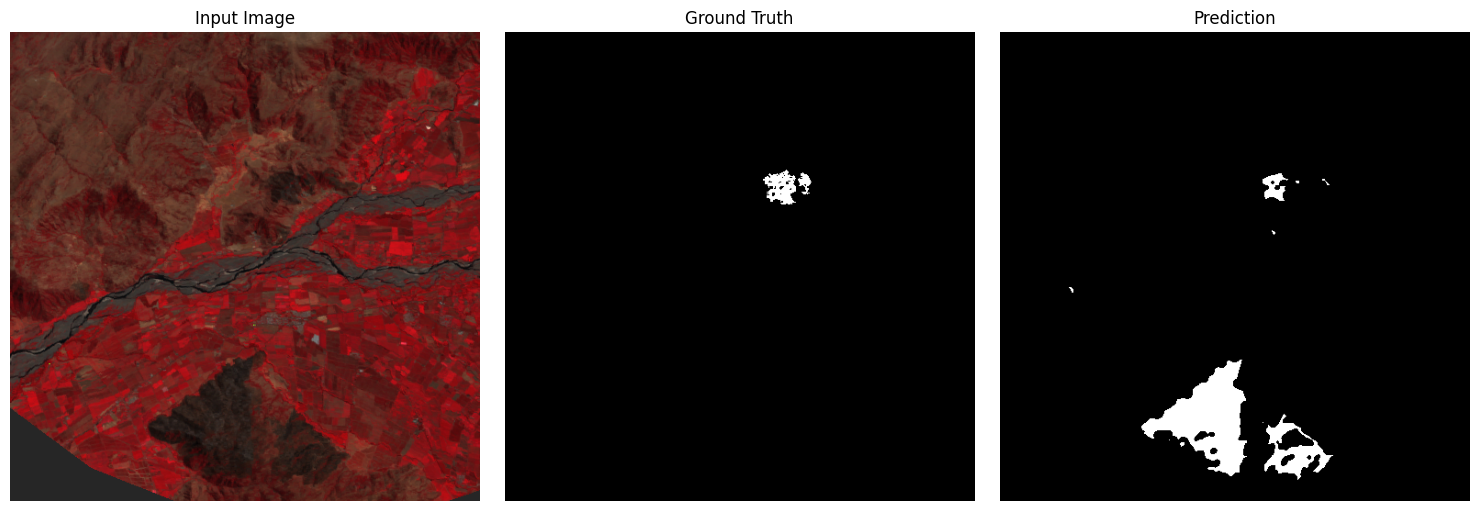

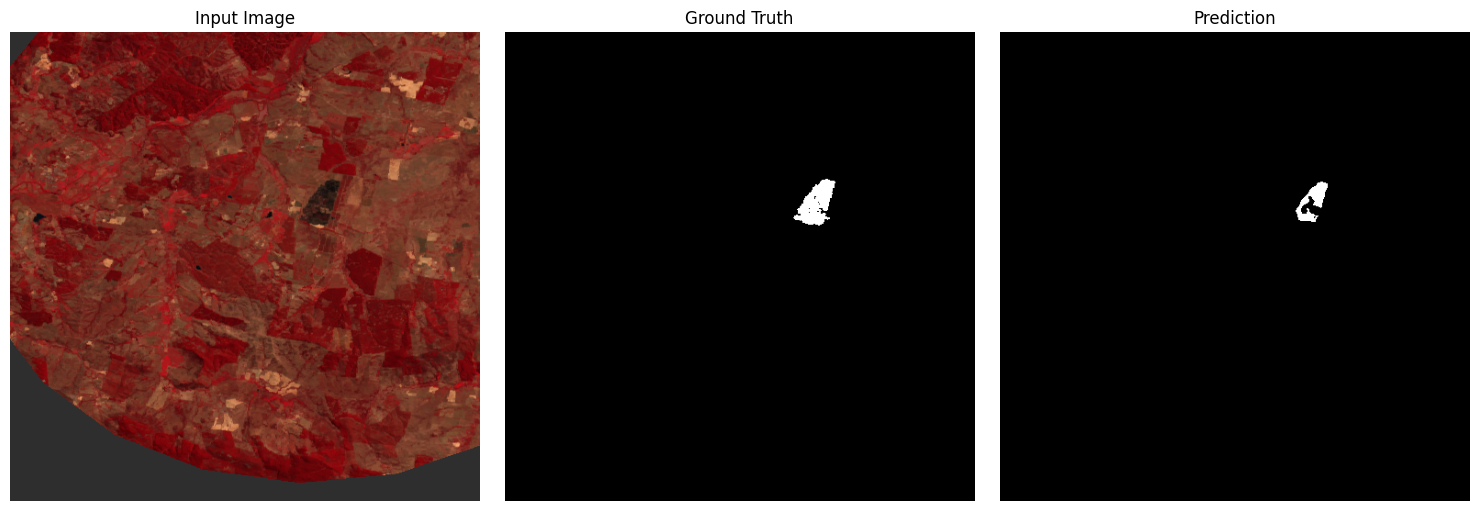

In [15]:
def show_predictions(num_examples=3):
    model.eval()
    count = 0

    with torch.no_grad():
        for imgs, masks in val_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            preds = torch.sigmoid(preds) > 0.5

            for i in range(imgs.shape[0]):
                img = imgs[i].cpu().numpy()
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                if img.shape[0] >= 3:
                    rgb = np.stack([img[3], img[2], img[1]], axis=-1)
                else:
                    rgb = np.repeat(img[0][..., np.newaxis], 3, axis=-1)

                rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb) + 1e-8)

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(rgb)
                axs[0].set_title("Input Image")
                axs[1].imshow(mask, cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred, cmap='gray')
                axs[2].set_title("Prediction")

                for ax in axs:
                    ax.axis('off')

                plt.tight_layout()
                plt.show()

                count += 1
                if count >= num_examples:
                    return
print("\nTraining complete. Showing example predictions...")
show_predictions(num_examples=5)